In [1]:
%matplotlib inline

# main libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# establish sql connection
import psycopg2 
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL

# additional imports from standart lib
import os
import re
from collections import defaultdict

In [2]:
# set pandas options 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# csv repo
data_source = 'data_csv'

# establish URL for connection to the database 
url_object = URL.create(
    'postgresql+psycopg2',
    username='postgres',
    password='Ee123456!',
    host='localhost',
    database='Masters:Programing_with_python',
)

# set matplotlib style
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 200
plt.close('all')

# Additional exception classes

In [3]:
class CSVReadErr(Exception):
    def __init__(self, message='Error reading CSV file'):
        self.message = message
        super().__init__(self.message)

class LenMismatchErr(Exception):
    def __init__(self, 
                 train_dim, 
                 ideal_dim, 
                 message='Mismatch in legth between ideal and training data:'):
        self.message = '\n'.join([
            message, 
            f'Amout of train points {train_dim}', 
            f'Amout of ideal points {ideal_dim}'])
        super().__init__(self.message)

class MissPointsErr(Exception):
    def __init__(self, message='Some points missing, features(x) are not equal'):
        self.message = message
        super().__init__(self.message)


# Init main classes

In [4]:
class Colors:
    def __init__(self):
        self.__color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        self.current_index = 0
        
    @property
    def next_color(self):
        color = self.__color_cycle[self.current_index]
        self.current_index = (self.current_index + 1) % len(self.__color_cycle)
        return color
    
    @property
    def reset(self):
        self.current_index = 0


class CSVToDataBase:
    def __init__(self, csv_name, csv_source, db_name, db_url):
        self.csv_name = csv_name
        self.db_name = db_name
        self.url = db_url
        self.csv_source = csv_source
        self.col_names = list()
        
    def rename_columns(self, col_names):
        self.col_names = col_names    

    def _create_table(self, engine):
        df = pd.read_csv(os.path.join(self.csv_source, self.csv_name))
        if self.col_names:
            df.columns = self.col_names           
        df.to_sql(self.db_name, engine, if_exists='replace', index=False)

    def create(self):
        engine = create_engine(self.url, pool_pre_ping=True)
        self._create_table(engine)
        print(f'Database "{self.db_name}" was created!')


class CustomDF(pd.DataFrame):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    @property
    def _constructor(self):
        return CustomDF
    
    @classmethod
    def read_sql_query(cls, query, url, *args, **kwargs):
        """
        Read SQL query into a CustomDF object.
        Returns a table of data corresponding to the result of the query string.
        
        Parameters
        ----------
        query: str 
            SQL query to be executed.
        url: sqlalchemy.engine.URL object 
            /..add../
        
        Returns
        -------
        CustomDF 
            A custom DataFrame object that contains the result set of the
            executed SQL query, in relation to the specified database connection.
        """
        engine = create_engine(url, pool_pre_ping=True)
        with engine.connect() as conn:
            resul_df = pd.read_sql_query(text(query), con=conn, *args, **kwargs)
            return  cls(resul_df)
    
    @classmethod 
    def read_by_lines(cls, file_name, data_source, new_col_names=[]):
        """
        Read CSV file line by line into a CustomDF object.
        CSV file must contain columns name in fi
        
        Parameters
        ----------
        file_name: str
            Name of the CSV file.
        data_source: str | os.path object
            Corresponding to the path to the directory with CSV files.
        new_col_names: list; optional
            Insert new columns names   
        
        Returns
        -------
        CustomDF
            A custom DataFrame object containing the result set of the data from the 
            CSV file.
        """
        try:
            file_path = os.path.join(data_source, file_name)
            rows = []
            # read CSV file line by line
            with open(file_path, 'r') as file:
                # init CustomDF object
                columns = file.readline().strip().split(',')
                if new_col_names:
                    df = cls(columns=new_col_names)
                else:
                    df = cls(columns=columns)
                
                # iter trought lines
                for line in file:
                    values = line.strip().split(',')
                    rows.append(values)
                
                # add file data to CustomDF object    
                df = pd.concat([df, CustomDF(rows, columns=df.columns)], ignore_index=True)
                # change dtypes to numeric
                df = df.astype(float)
            return df

        except Exception as e:
            raise CSVReadErr(f'Error reading CSV file: {str(e)}')
            
    @classmethod 
    def mean_square_error(cls, ideal, train):
        
        # check features
        if not (ideal.columns == 'X').any() or not (train.columns == 'X').any():
            raise IndexError('Feature "X" has not been found')
        # check matching columns len
        if not train.shape[0] == ideal.shape[0]:
            raise LenMismatchErr(train.shape[0], ideal.shape[0])
        # check missing points
        if not (ideal['X'] == train['X']).all():
            raise MissPointsErr()
        
        # split data
        features = train['X']
        train_lables = train.drop(columns=['X'])
        ideal_lables = ideal.drop(columns=['X'])
        
        # init mse datatable
        MSE = cls()
        
        for (train_name, train_lable) in train_lables.iteritems():
            frame = cls._sq_err_matrix(ideal_lables, train_lable)
            frame.loc['sum'] = frame.sum()
            MSE[train_name] = frame.loc['sum'] / features.shape[0]
            
        MSE.index = [idx.split('_')[-1] for idx in MSE.index]
        MSE.index.name = 'No ideal func'
        
        return MSE
    
    @classmethod
    def _sq_err_matrix(cls, ideal_lables, train_col):
        sq_err_matrix = cls().from_dict({'reference': train_col})
        for (ideal_name, ideal_lable) in ideal_lables.iteritems():
            deviation = sq_err_matrix['reference'] - ideal_lable
            sq_err_matrix[f'sq_dif_{ideal_name}'] = np.power(deviation, 2)
        return sq_err_matrix.drop(columns=['reference'])
    
    @classmethod
    def find_best_fit(cls, mse):
        best_fit = cls({
            'No. of ideal func': mse.iloc[mse.agg(np.argmin)].index,
            'MSE': mse.agg(np.min)
        }).transpose()
        return best_fit
    
    def _strip_brackets(self, input_list):
        # delistification
        if len(input_list)==1: 
            return re.sub(r'\([^)]*\)', '', input_list[0])
        # return list
        return [re.sub(r'\([^)]*\)', '', string) for string in input_list] 
    
    def ideal_to_list(self, strip_brackets=False):
        chosen_ideal = self.loc['No. of ideal func'].to_list()
        if strip_brackets:
            chosen_ideal = self._strip_brackets(input_list=chosen_ideal)
        return chosen_ideal
    
    def bar_plot(self, strip_brackets=False):
        if strip_brackets:    
            index = self.index.to_list()
            self.index = self._strip_brackets(input_list=index)
            
        ax = self.plot(
            figsize=(8.27, 11.69),
            kind='barh', 
            logx=True,
            fontsize=10,
        )
        ax.set_title('MSE for each train func in log scale', fontsize=12)
        ax.invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    def scatter_on_4funcs(self, train):
        
        fig, _ = plt.subplots(2, 2, figsize=(8.27, 11.69), sharex=True)
        axis = fig.get_axes() # get list of axis
        color = Colors() # set color obj
        X = train['X'] # get features
        train = train.drop(columns=['X']) # get lables

        plt.subplots_adjust(hspace=0.05, top=0.95) 
        fig.suptitle('Selected Ideal_functions with corresponding Test_data')

        # set lables
        for idx, ax in enumerate(axis):
            if idx>1:
                ax.set(xlabel='x')
            if idx%2==0:
                ax.set(ylabel='y')

        # zip axis, train and ideal data
        ziped_obj = zip(axis, train.iteritems(), self.iteritems())
        # plot graphs
        for ax, (train_name, train_data), (ideal_name, ideal_data) in ziped_obj:
            ax.scatter(x=X, y=train_data, alpha=0.3, c='C5')
            ax.plot(X, ideal_data, c=color.next_color)
            ax.legend([train_name, ideal_name], loc='upper right')
        
        plt.tight_layout()
        plt.show()
    
    @classmethod        
    def lmerge(cls, test, ideal, chosen_ideal_labels, *args, **kwargs):
        # check missing points
        if not (test['X'].isin(ideal['X'])).all():
            raise MissPointsErr()
        # merge CustomDF's
        merged_df = pd.merge(
            left=test,
            right=ideal[chosen_ideal_labels + ['X']],
            how='left',
            on='X',
            *args, 
            **kwargs
        )
        return cls(merged_df)
    
    def plot_ideal_to_test(self, chosen_ideal_labels, test_label='Y(test func)'):
        ax2 = self.plot(
            x='X', 
            y=chosen_ideal_labels, 
            ylabel='Y', 
            figsize=(8.27, 5.84)
        )
        ax2.set_title('Selected Ideal_functions and Test_data', fontsize=12)
        ax2.plot(merged_df['X'], merged_df[test_label], 'C5o:', mec='1.0')
        
        labels = chosen_ideal_labels + [test_label]
        ax2.legend(labels=labels, loc='upper left', bbox_to_anchor=(1, 1))
        plt.subplots_adjust(right=0.8)
        plt.tight_layout()
        plt.show()
    
    def fit(self, chosen_ideal_labels, margin=np.sqrt(2), nested_list=False):
        test_mapped = CustomDF(columns=['X (test func)', 
                                        'Y (test func)', 
                                        'Delta Y (test func)', 
                                        'No. of ideal func'])
        idx = 0
        counter = defaultdict(int)
        for i, row in self.iterrows():
            # init row that will be implicted in df
            row_test_data = [row['X'].round(2), row['Y(test func)']] # 1st and 2nd columns
            delta, No = list(), list() # 3rd and 4th columns

            for ideal_func_No, div in zip(chosen_ideal_labels, row[chosen_ideal_labels]):
                if abs(div - row['Y(test func)']) < margin:
                    fitted_func = self._strip_brackets([ideal_func_No])
                    counter[fitted_func] += 1
                    delta.append(round(abs(div - row['Y(test func)']),6))
                    No.append(fitted_func)
            
            # missing values case
            if not delta:
                delta = [pd.NA]
                No = [pd.NA]

            if nested_list:
                # covering into list multiple values
                if len(delta) > 1:
                    delta = [delta]
                    No = [No]
                test_mapped.loc[i] = row_test_data + delta + No
            else:
                # duplicate row with multiple fitting ideal_func datapoints
                for d, N in zip(delta, No):
                    test_mapped.loc[idx] = row_test_data + [d, N]
                    idx+=1
                    
        return test_mapped, counter
    
    def to_db(self, db_name, url):
        engine = create_engine(url, pool_pre_ping=True)      
        self.to_sql(db_name, engine, if_exists='replace', index=False)
        print(f'Database "{db_name}" was created!')

# Converting and Load data
## First will create databases 
According to the task:  Your Python program needs to be able to
independently compile a SQLite database (file) ideally via sqlalchemy and load the training data into a single fivecolumn spreadsheet/table in the file. Its first column depicts the x-values of all functions. The fifty ideal functions, which are also
provided via a CSV-file, must be loaded into another table. Likewise, the first column depicts the x-values,
meaning there will be 51 columns overall. 

In [5]:
db_creator = CSVToDataBase('train.csv', 
                           data_source, 
                           'The training data', 
                           url_object)
db_creator.rename_columns(['X'] + [f'Y{i}(training func)' for i in range(1, 5)])
db_creator.create()

Database "The training data" was created!


In [6]:
db_creator = CSVToDataBase('ideal.csv', 
                           data_source, 
                           'The ideal functions', 
                           url_object)
db_creator.rename_columns(['X'] + [f'Y{i}(ideal func)' for i in range(1, 51)])
db_creator.create()

Database "The ideal functions" was created!


## Read train and ideal from database

In [7]:
train = CustomDF.read_sql_query('SELECT * FROM "The training data"', url_object)
ideal = CustomDF.read_sql_query('SELECT * FROM "The ideal functions"', url_object)

## Read the test data
According to the task: the test data must be loaded line-by-line from another CSV-file and

In [8]:
test = CustomDF.read_by_lines(file_name='test.csv', 
                              data_source=data_source, 
                              new_col_names=['X', 'Y(test func)'])

# Sorting data before computing 
## Sort values by 'X' feature

In [9]:
ideal = ideal.sort_values(by='X')
train = train.sort_values(by='X')
test = test.sort_values(by='X')

## Show loaded data

In [10]:
ideal.head()

,X,Y1(ideal func),Y2(ideal func),Y3(ideal func),Y4(ideal func),Y5(ideal func),Y6(ideal func),Y7(ideal func),Y8(ideal func),Y9(ideal func),Y10(ideal func),Y11(ideal func),Y12(ideal func),Y13(ideal func),Y14(ideal func),Y15(ideal func),Y16(ideal func),Y17(ideal func),Y18(ideal func),Y19(ideal func),Y20(ideal func),Y21(ideal func),Y22(ideal func),Y23(ideal func),Y24(ideal func),Y25(ideal func),Y26(ideal func),Y27(ideal func),Y28(ideal func),Y29(ideal func),Y30(ideal func),Y31(ideal func),Y32(ideal func),Y33(ideal func),Y34(ideal func),Y35(ideal func),Y36(ideal func),Y37(ideal func),Y38(ideal func),Y39(ideal func),Y40(ideal func),Y41(ideal func),Y42(ideal func),Y43(ideal func),Y44(ideal func),Y45(ideal func),Y46(ideal func),Y47(ideal func),Y48(ideal func),Y49(ideal func),Y50(ideal func)
0,-20.0,-0.912945,0.408082,9.087055,5.408082,-9.087055,0.912945,-0.839071,-0.850919,0.816164,18.258905,-20.0,-58.0,-45.0,20.0,13.00,400.00,-400.00,800.00,410.00,289.00,-8000.000,8000.000,8000.000,-16000.000,-23995.000,-5832.000,10648.000,-8020.000,-7600.000,-8795.000,20.0,4.472136,20.124610,-0.746414,10.0,100.0,-20.0,-1.321027,399.08707,899.59190,-40.456474,40.204040,2.995732,-0.008333,12.995732,5.298317,-5.298317,-0.186278,0.912945,0.396850
1,-19.9,-0.867644,0.497186,9.132356,5.497186,-9.132356,0.867644,-0.865213,0.168518,0.994372,17.266117,-19.9,-57.7,-44.8,19.9,12.95,396.01,-396.01,792.02,406.01,285.61,-7880.599,7880.599,7880.599,-15761.198,-23636.797,-5735.339,10503.459,-7900.499,-7484.589,-8667.619,19.9,4.460942,20.025234,-0.620450,9.9,99.5,-19.9,-1.364830,395.14236,893.51280,-40.233820,40.048590,2.990720,-0.008340,12.990720,5.293305,-5.293305,-0.215690,0.867644,0.476954
2,-19.8,-0.813674,0.581322,9.186326,5.581322,-9.186326,0.813674,-0.889191,0.612391,1.162644,16.110740,-19.8,-57.4,-44.6,19.8,12.90,392.04,-392.04,784.08,402.04,282.24,-7762.392,7762.392,7762.392,-15524.784,-23282.176,-5639.752,10360.232,-7782.192,-7370.352,-8541.472,19.8,4.449719,19.925863,-0.475739,9.8,99.0,-19.8,-1.394996,391.22632,887.45870,-40.006836,39.890660,2.985682,-0.008347,12.985682,5.288267,-5.288267,-0.236503,0.813674,0.549129
3,-19.7,-0.751573,0.659649,9.248426,5.659649,-9.248426,0.751573,-0.910947,-0.994669,1.319299,14.805996,-19.7,-57.1,-44.4,19.7,12.85,388.09,-388.09,776.18,398.09,278.89,-7645.373,7645.373,7645.373,-15290.746,-22931.120,-5545.233,10218.313,-7665.073,-7257.283,-8416.553,19.7,4.438468,19.826498,-0.316436,9.7,98.5,-19.7,-1.411223,387.33844,881.43036,-39.775787,39.729824,2.980619,-0.008354,12.980619,5.283204,-5.283204,-0.247887,0.751573,0.612840
4,-19.6,-0.681964,0.731386,9.318036,5.731386,-9.318036,0.681964,-0.930426,0.774356,1.462772,13.366487,-19.6,-56.8,-44.2,19.6,12.80,384.16,-384.16,768.32,394.16,275.56,-7529.536,7529.536,7529.536,-15059.072,-22583.607,-5451.776,10077.696,-7549.136,-7145.376,-8292.856,19.6,4.427189,19.727139,-0.147038,9.6,98.0,-19.6,-1.413350,383.47803,875.42860,-39.540980,39.565693,2.975530,-0.008361,12.975530,5.278115,-5.278115,-0.249389,0.681964,0.667902


In [11]:
train.head()

,X,Y1(training func),Y2(training func),Y3(training func),Y4(training func)
0,-20.0,39.778572,-40.078590,-20.214268,-0.324914
1,-19.9,39.604813,-39.784000,-20.070950,-0.058820
2,-19.8,40.099070,-40.018845,-19.906782,-0.451830
3,-19.7,40.151100,-39.518402,-19.389118,-0.612044
4,-19.6,39.795662,-39.360065,-19.815890,-0.306076


In [12]:
test.head()

,X,Y(test func)
83,-20.0,-19.284970
11,-19.8,-19.915014
85,-19.3,-38.458572
3,-19.2,-37.170870
61,-19.1,-38.155376


# MSE
## Calculating mse for train and ideal data

In [13]:
mse = CustomDF.mean_square_error(ideal, train)
mse.head()

,Y1(training func),Y2(training func),Y3(training func),Y4(training func)
No ideal func,,,,
Y1(ideal func),531.472176,534.268865,134.514539,0.552048
Y2(ideal func),532.346369,533.420559,133.876070,0.614010
Y3(ideal func),629.273209,636.107997,235.501458,100.253745
Y4(ideal func),556.725800,559.819042,159.848446,25.943774
Y5(ideal func),636.494906,630.439191,232.010051,100.850119


## Ploting calculated mse
For better clarity, graphs are plotted on a logarithmic scale

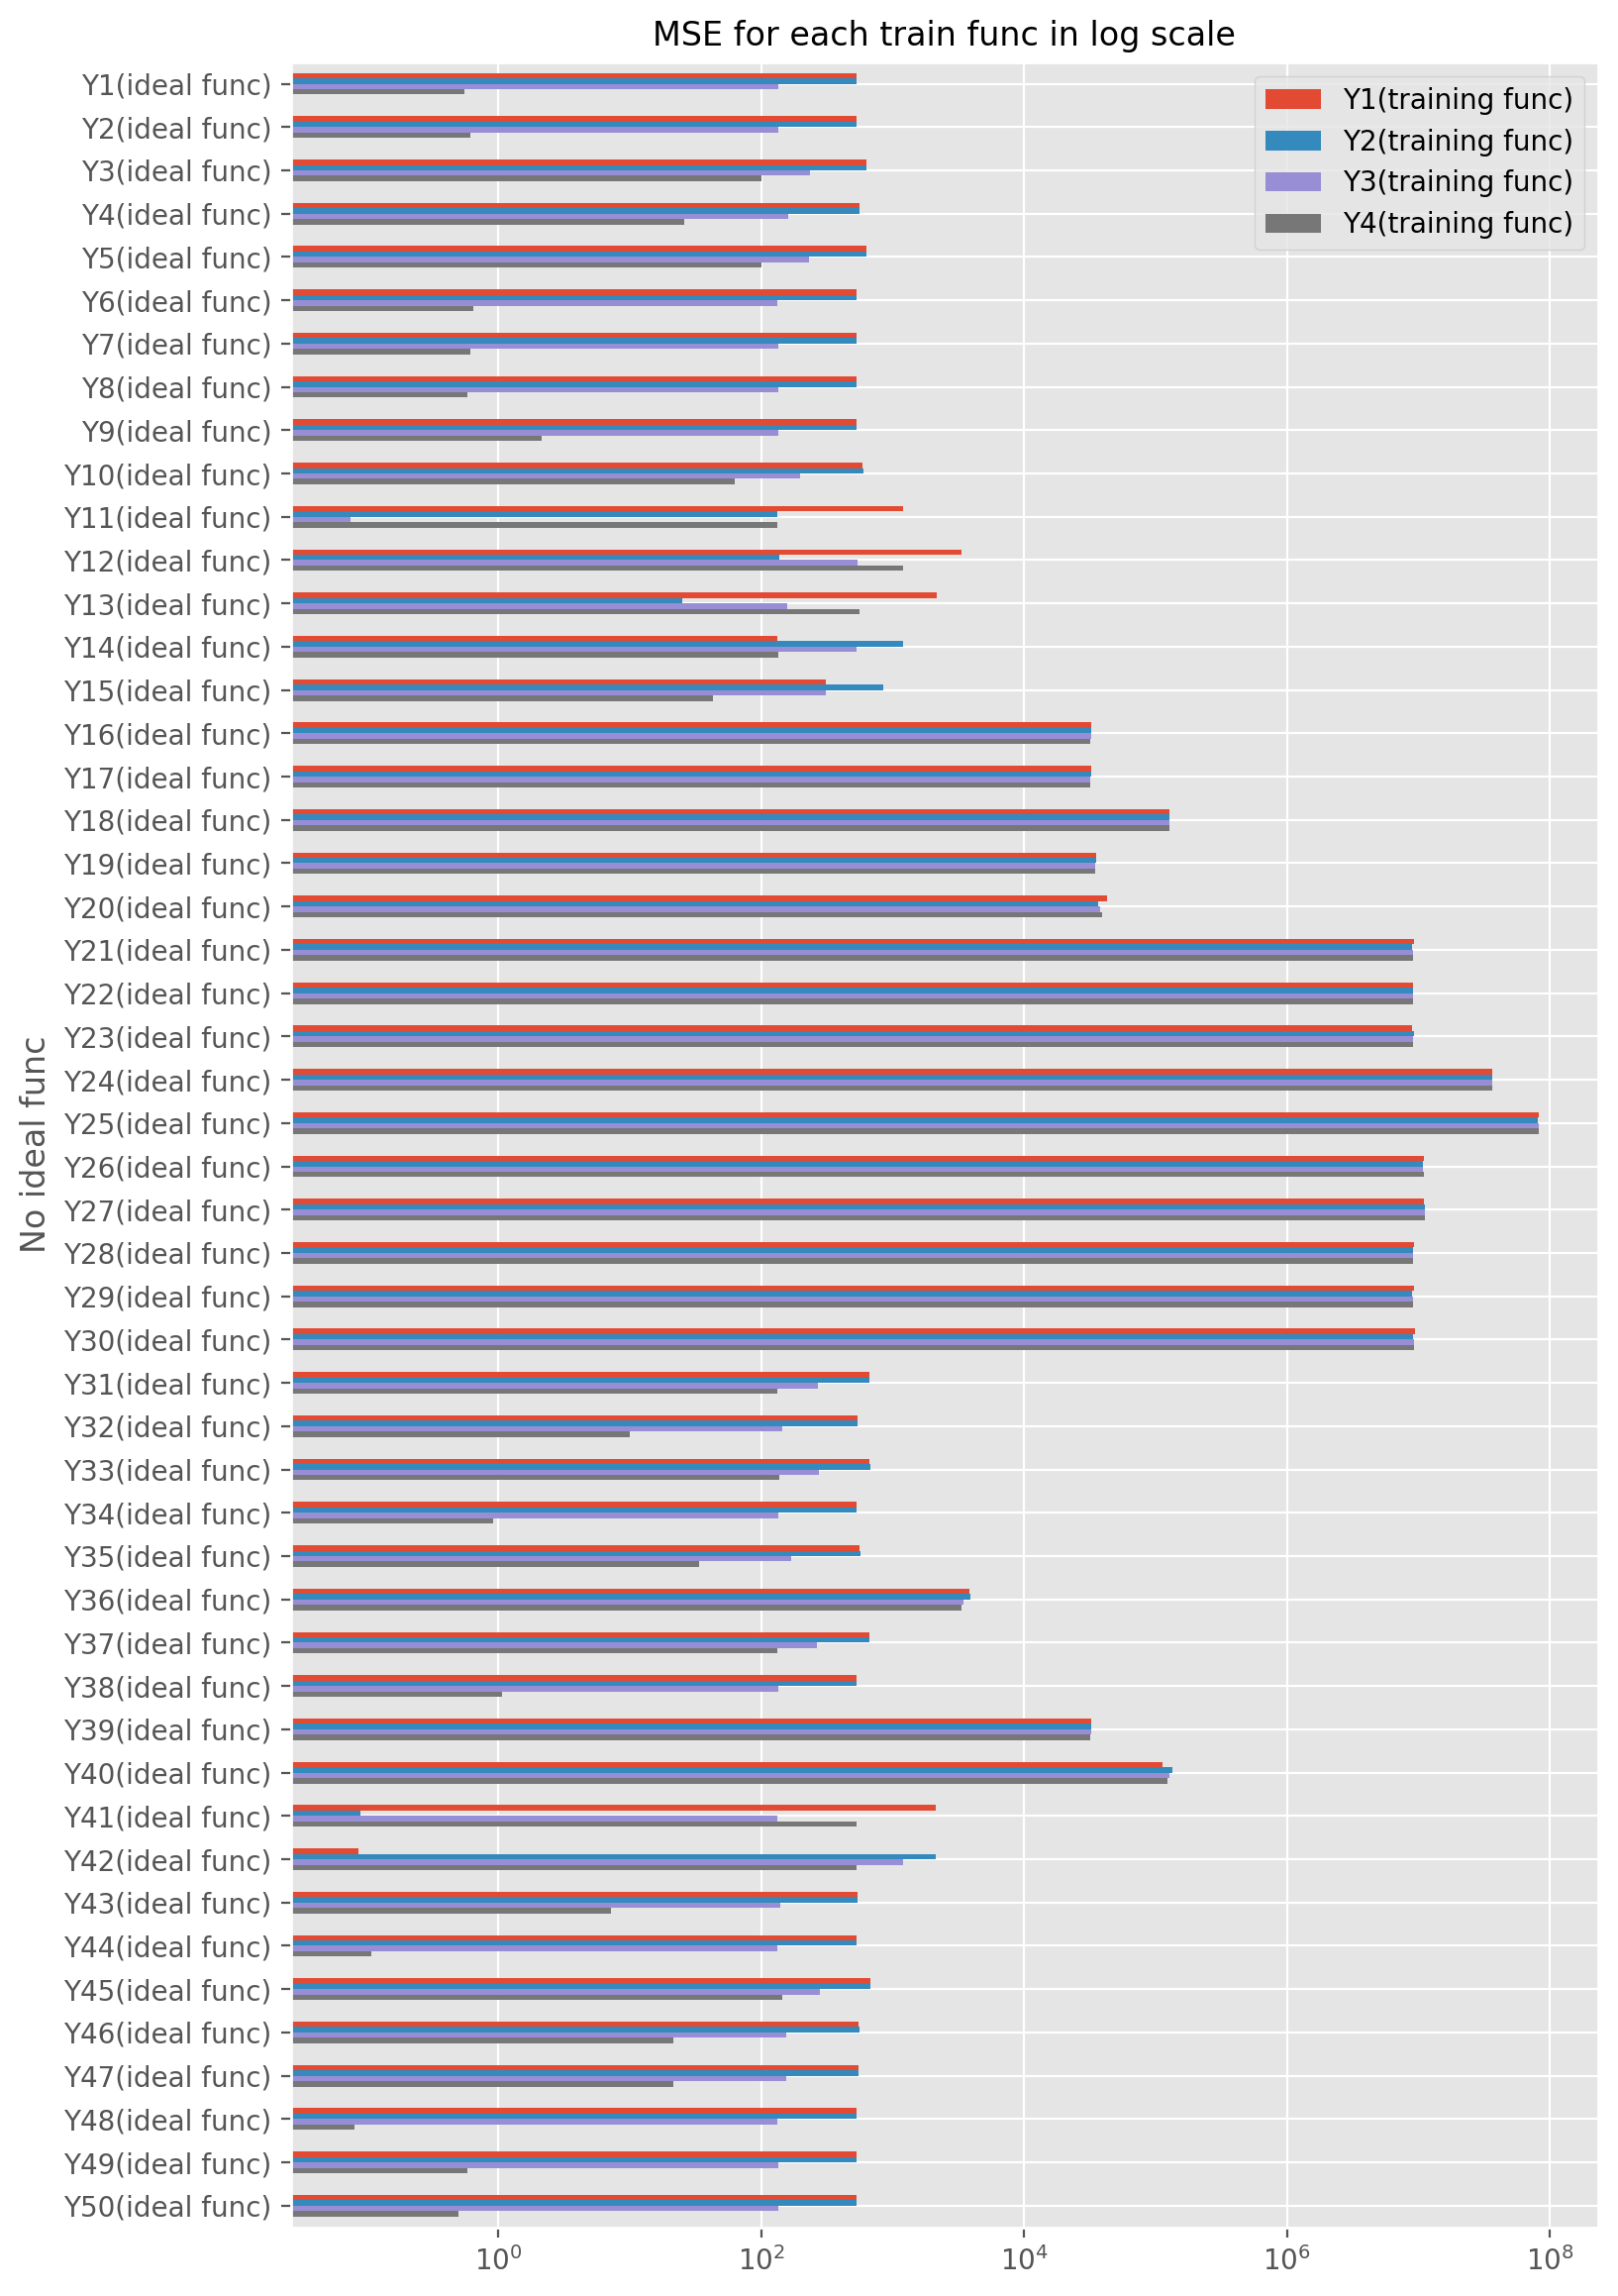

In [14]:
mse.bar_plot()

In [15]:
best_fit = CustomDF.find_best_fit(mse) # find best fitted data
chosen_ideal_labels = best_fit.ideal_to_list() # extract ideal fuction names
chosen_ideal = ideal[chosen_ideal_labels] # extract ideal fuction data
best_fit

,Y1(training func),Y2(training func),Y3(training func),Y4(training func)
No. of ideal func,Y42(ideal func),Y41(ideal func),Y11(ideal func),Y48(ideal func)
MSE,0.085616,0.089005,0.074655,0.079909


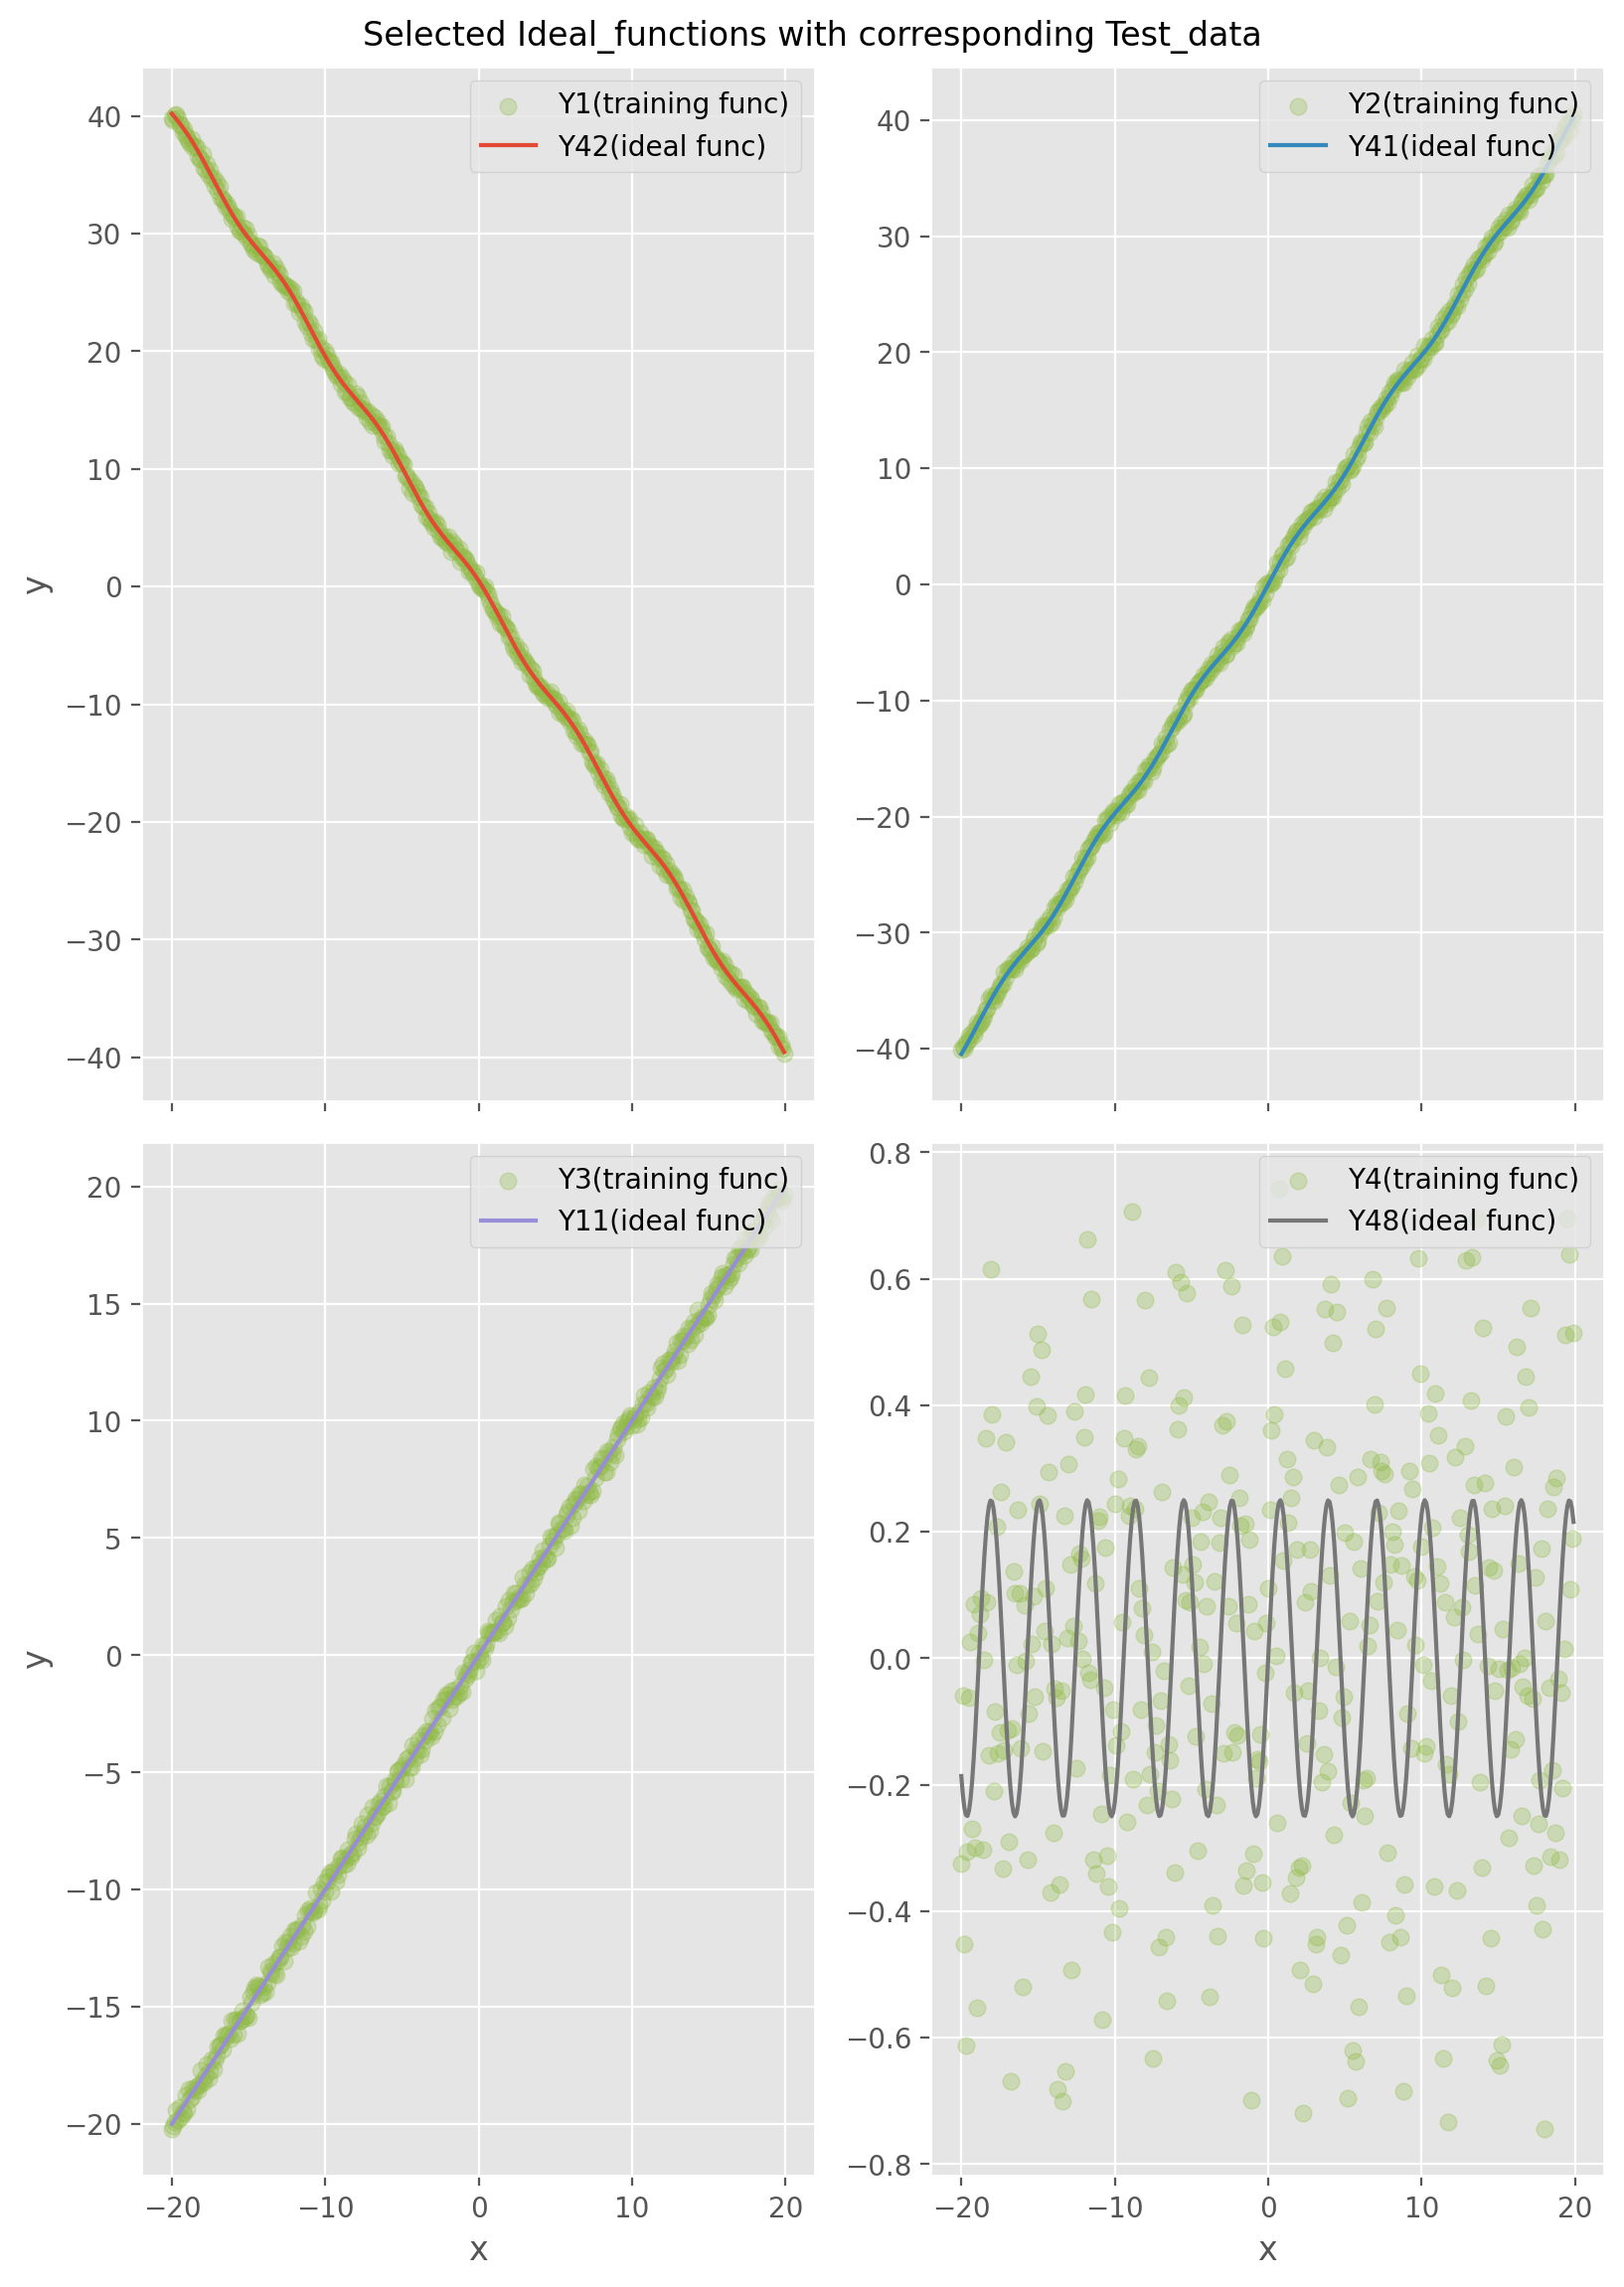

In [16]:
chosen_ideal.scatter_on_4funcs(train)

# Finding best fitting points

## 

In [17]:
merged_df = CustomDF.lmerge(test, ideal, chosen_ideal_labels)
merged_df.head()

,X,Y(test func),Y42(ideal func),Y41(ideal func),Y11(ideal func),Y48(ideal func)
0,-20.0,-19.284970,40.204040,-40.456474,-20.0,-0.186278
1,-19.8,-19.915014,39.890660,-40.006836,-19.8,-0.236503
2,-19.3,-38.458572,39.050125,-38.817684,-19.3,-0.195970
3,-19.2,-37.170870,38.869610,-38.571660,-19.2,-0.161224
4,-19.1,-38.155376,38.684402,-38.323917,-19.1,-0.120051


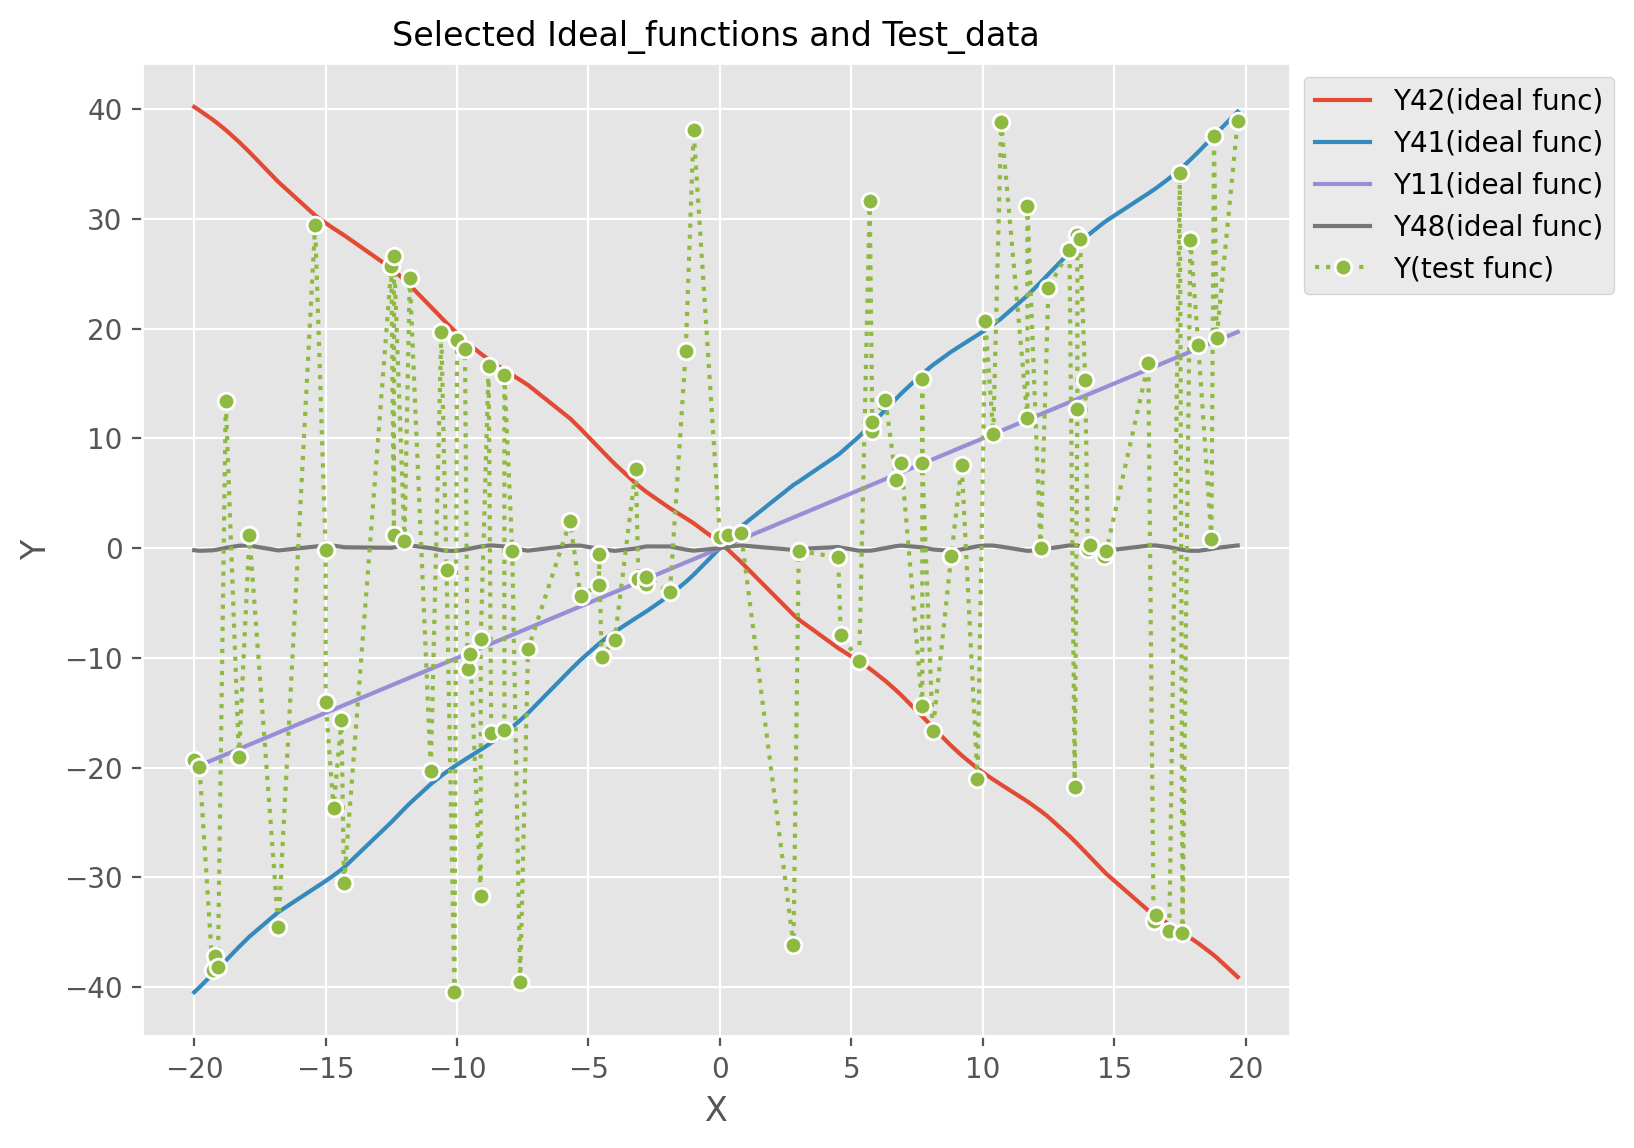

In [18]:
merged_df.plot_ideal_to_test(chosen_ideal_labels)

## Creating CustomDF of the test-data, with mapping and y-deviation

In [19]:
ans, counts = merged_df.fit(chosen_ideal_labels) # nested_list=False

### Count fitted points

In [20]:
for key, value in counts.items():
    print(f'ideal function {key} fit {value} test point(s)')

ideal function Y11 fit 26 test point(s)
ideal function Y41 fit 26 test point(s)
ideal function Y48 fit 18 test point(s)
ideal function Y42 fit 21 test point(s)


### Show answer

In [21]:
ans

,X (test func),Y (test func),Delta Y (test func),No. of ideal func
0,-20.0,-19.284970,0.715030,Y11
1,-19.8,-19.915014,0.115014,Y11
2,-19.3,-38.458572,0.359112,Y41
3,-19.2,-37.170870,1.400790,Y41
4,-19.1,-38.155376,0.168541,Y41
5,-18.8,13.410461,NaN,NaN
6,-18.3,-19.014248,0.714248,Y11
7,-17.9,1.169216,0.932569,Y48
8,-16.8,-34.480774,1.324558,Y41
9,-15.4,29.490164,0.833360,Y42


## Load data from CustomDF to sql database

In [22]:
ans.to_db('test-data, with mapping and y-deviation', url_object)

Database "test-data, with mapping and y-deviation" was created!
